# Captcha Solver

At first we include all the necessary libraries.

In [1]:
import argparse
import json
import string
import os
import shutil
import uuid
from captcha.image import ImageCaptcha

import itertools

import os
import cv2
import numpy as np
from random import random

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Input
import matplotlib.pyplot as plt

Using TensorFlow backend.


Below, there are functions for generating CAPTCHAs. The `_gen_captcha` function gets a *directory* in which the generated CAPTCHAs will store, *number of letters* that each CAPTCHA contains, *width* and *height* of the image and the last but not least, the *number of repetition* which represents the number of different CAPTCHA image that will be generated for each permutation.
The function checks the directory and if it does not exist, it will create it, and otherwise, if remove its component to create the CAPTCHAs again.
The CAPTCHAs are created using `ImageCaptcha` library in python and then stored with the following name format: `<CAPTCHA_TRUE_LABELS>_<RANDOM_GENERATED_NAME>.png`. The randomly generated name is used to distinguish captcha with the same label/value.

In [2]:
def _gen_captcha(img_dir, num_of_letters, num_of_repetition, width, height):
    if os.path.exists(img_dir):
        shutil.rmtree(img_dir)
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)

    image = ImageCaptcha(width=width, height=height)

    for counter in range(num_of_repetition):
        print('generating %d/%d' % (counter + 1, num_of_repetition))
        for i in itertools.permutations([str(c) for c in range(10)], num_of_letters):
            captcha = ''.join(i)
            fn = os.path.join(img_dir, '%s_%s.png' % (captcha, uuid.uuid4()))
            image.write(captcha, fn)


def gen_dataset(path, num_of_repetition, num_of_letters, width, height):
    _gen_captcha(os.path.join(path, 'data'), num_of_letters, num_of_repetition, width, height)
    print('Finished Data Generation')

And here are configuration parameters for the application:

In [3]:
BATCH_SIZE = 128
NUM_OF_LETTERS = 5
EPOCHS = 35
IMG_ROW, IMG_COLS = 50, 135

In [4]:
# Non-configs
PATH = os.getcwd()
DATA_PATH = os.path.join(PATH, 'train')

The `load_data` function will load the previously generated CAPTCHAs into **test** and **train** sets. The generated is assigned to **test** or **train** randomly regarding the split ratio that is given as `test_split`.
Besides, the loaded image is reduced to half-sized and is converted to *gray-scale* image to reduce complexity.

In [5]:
def load_data(path, test_split=0.1):
    print 'loading dataset...'
    y_train = []
    y_test = []
    x_train = []
    x_test = []

    # r=root, d=directories, f = files
    counter = 0
    for r, d, f in os.walk(path):
        for fl in f:
            if '.png' in fl:
                flr = fl.split('_')[0]
                counter += 1
                label = np.zeros((NUM_OF_LETTERS, 10))
                for i in range(NUM_OF_LETTERS):
                    label[i, int(flr[i])] = 1

                img = cv2.imread(os.path.join(r, fl))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (135/2, 50/2), interpolation=cv2.INTER_AREA)
                img = np.reshape(img, (img.shape[0], img.shape[1], 1))

                if random() < test_split:
                    y_test.append(label)
                    x_test.append(img)
                else:
                    y_train.append(label)
                    x_train.append(img)

    print('dataset size:', counter, '(train=%d, test=%d)' % (len(y_train), len(y_test)))
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

Then, if the dataset does not exists, we try to create it:

In [6]:
if not os.path.exists(DATA_PATH):
    print('Generating Dataset')
    gen_dataset(DATA_PATH, 8, NUM_OF_LETTERS, IMG_COLS, IMG_ROW)

Generating Dataset
generating 1/8
generating 2/8
generating 3/8
generating 4/8
generating 5/8
generating 6/8
generating 7/8
generating 8/8
Finished Data Generation


Here, we load the data and convert them in a way that is appropriate for CNNs. We scale the image values from 0~255 range to just between 0~1.

In [7]:
x_train, y_train, x_test, y_test = load_data(DATA_PATH)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

loading dataset...
('dataset size:', 241920, '(train=217835, test=24085)')
(217835, 25, 67, 1)
(217835, 5, 10)
(24085, 25, 67, 1)
(24085, 5, 10)


If `n` be the number of samples, `d` the number of digits, and the `c` the number of character per digits (which is this case is 10) then, here we reshape the label sets from `n x d x c` to `n x c x d` in order to feed them to the network correctly.

In [8]:
s_train = []
s_test = []
for i in range(NUM_OF_LETTERS):
    s_train.append(y_train[:, i, :])
    s_test.append(y_test[:, i, :])

Finally, we create a model network. The network has the input with the shape of `25x67x1` which is the shape of the reduced-size image that is turned into a gray-scale image. Then, the first layer is a same-padding convolutional layer with 32, `ReLU`-activation unit followed by a Max-Pooling layer. Then the same repeats with 48 and 64 units. Then a 512 dense layer is employed followed by `d` (number of letters) softmax layers.
Then the `binary-cross-entropy` has been chosen to compare the prediction with the truth value which then used by *Adam* optimizer to train the network.

In [9]:
save_dir = os.path.join(PATH, 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

input_layer = Input((25, 67, 1))
x = Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=48, kernel_size=(5, 5), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)

out = [Dense(10, name='digit%d' % i, activation='softmax')(x) for i in range(NUM_OF_LETTERS)]
model = Model(inputs=input_layer, outputs=out)

# initiate Adam optimizer
opt = keras.optimizers.Adam(lr=0.0001, beta_1=0.99, beta_2=0.9999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()    

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25, 67, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 25, 67, 32)   832         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 12, 33, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 12, 33, 48)   38448       max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

Before we start training the model, we have defined a function called `plot_diagram` to plot the **loss** and **accuracy** metric of the network. 

In [10]:
%matplotlib inline

digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
val_digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
loss = []
val_loss = []

def plot_diagram(digit_acc_now, val_digit_acc_now, loss_now, val_loss_now):
    global digit_acc, val_digit_acc, loss, val_loss
    for i in range(NUM_OF_LETTERS):
        digit_acc[i].extend(digit_acc_now[i])
        val_digit_acc[i].extend(val_digit_acc_now[i])
    loss.extend(loss_now)
    val_loss.extend(val_loss_now)
    
    
    for i in range(NUM_OF_LETTERS):
        plt.plot(digit_acc[i], label='digit%d_acc' % i)
        plt.plot(val_digit_acc[i], label='val_digit%d_acc' % i)
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Plot training & validation loss values
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

And here is the trainig part, in which we train the network for `EPOCHS=100` epochs with the `BATCH_SIZE=128`.

In [11]:
history = model.fit(x_train, s_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=(x_test, s_test))

Train on 217835 samples, validate on 24085 samples
Epoch 1/35
217835/217835 [==============================] - 623s 3ms/step - loss: 1.3485 - digit0_loss: 0.2510 - digit1_loss: 0.2842 - digit2_loss: 0.2869 - digit3_loss: 0.2781 - digit4_loss: 0.2483 - digit0_acc: 0.9144 - digit1_acc: 0.9045 - digit2_acc: 0.9038 - digit3_acc: 0.9061 - digit4_acc: 0.9151 - val_loss: 0.7883 - val_digit0_loss: 0.1079 - val_digit1_loss: 0.1936 - val_digit2_loss: 0.2045 - val_digit3_loss: 0.1748 - val_digit4_loss: 0.1075 - val_digit0_acc: 0.9610 - val_digit1_acc: 0.9264 - val_digit2_acc: 0.9215 - val_digit3_acc: 0.9340 - val_digit4_acc: 0.9620
Epoch 2/35
217835/217835 [==============================] - 613s 3ms/step - loss: 0.7050 - digit0_loss: 0.0876 - digit1_loss: 0.1760 - digit2_loss: 0.1929 - digit3_loss: 0.1601 - digit4_loss: 0.0885 - digit0_acc: 0.9680 - digit1_acc: 0.9340 - digit2_acc: 0.9278 - digit3_acc: 0.9406 - digit4_acc: 0.9677 - val_loss: 0.4780 - val_digit0_loss: 0.0483 - val_digit1_loss: 0.1

217835/217835 [==============================] - 621s 3ms/step - loss: 0.0506 - digit0_loss: 0.0064 - digit1_loss: 0.0117 - digit2_loss: 0.0134 - digit3_loss: 0.0120 - digit4_loss: 0.0072 - digit0_acc: 0.9978 - digit1_acc: 0.9960 - digit2_acc: 0.9956 - digit3_acc: 0.9960 - digit4_acc: 0.9975 - val_loss: 0.0284 - val_digit0_loss: 0.0035 - val_digit1_loss: 0.0064 - val_digit2_loss: 0.0075 - val_digit3_loss: 0.0069 - val_digit4_loss: 0.0042 - val_digit0_acc: 0.9988 - val_digit1_acc: 0.9980 - val_digit2_acc: 0.9977 - val_digit3_acc: 0.9978 - val_digit4_acc: 0.9986
Epoch 30/35
217835/217835 [==============================] - 3578s 16ms/step - loss: 0.0480 - digit0_loss: 0.0060 - digit1_loss: 0.0112 - digit2_loss: 0.0128 - digit3_loss: 0.0115 - digit4_loss: 0.0066 - digit0_acc: 0.9979 - digit1_acc: 0.9962 - digit2_acc: 0.9957 - digit3_acc: 0.9960 - digit4_acc: 0.9977 - val_loss: 0.0290 - val_digit0_loss: 0.0035 - val_digit1_loss: 0.0063 - val_digit2_loss: 0.0076 - val_digit3_loss: 0.0070 - v

Here, we can see the loss value and accuracy metric for each digit in our output softmax layers. As can be seen below, the network is tends to learn to predict the digits correctly as the loss value reduces.

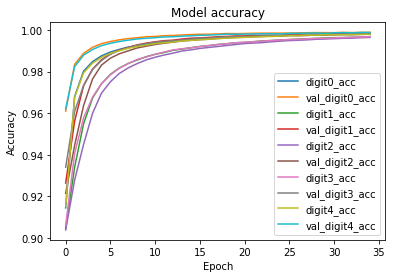

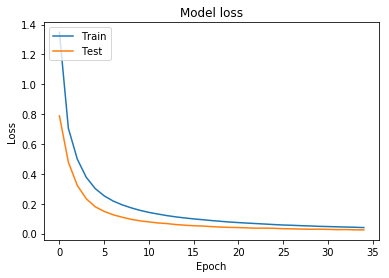

In [12]:
plot_diagram(
    [history.history['digit%d_acc' % i] for i in range(NUM_OF_LETTERS)],
    [history.history['val_digit%d_acc' % i] for i in range(NUM_OF_LETTERS)],
    history.history['loss'],
    history.history['val_loss'],
)

Finally, we save the mode to file for later usage, then we print the final **loss** and **accuracy** metrics.

In [32]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_train, s_train, verbose=1)
print('Train loss:     %.2f' % np.mean(scores[0:5]))
acc = 1.
for i in range(5):
    acc *= scores[6+i]
print('Train accuracy: %.2f' % (acc * 100.))

scores = model.evaluate(x_test, s_test, verbose=1)
print('Test loss:     %.2f' % np.mean(scores[0:5]))
acc = 1.
for i in range(5):
    acc *= scores[6+i]
print('Test accuracy: %.2f' % (acc * 100.))

217835/217835 [==============================] - 230s 1ms/step
Train loss:     0.01
Train accuracy: 99.60
24085/24085 [==============================] - 26s 1ms/step
Test loss:     0.01
Test accuracy: 99.20
